In [19]:
import pandas as pd
from pathlib import Path
from definitions import ROOT_DIR
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc, rc_context
import matplotlib
from seriate import seriate
from scipy.spatial.distance import pdist

matplotlib.rcParams['pdf.fonttype'] = 42
rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':12})

In [20]:
def get_class_size(metadata, class_column):
    sizes = metadata[class_column].value_counts()
    metadata['class_size'] = [sizes[k] for k in metadata[class_column]]
    return metadata


def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df


def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df


def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df


def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
    return data


def group_by_molecule(df, groupby_columns):
    '''
    Aggregate intensity and detection values per groupby columns
    '''          
    data = df.groupby(groupby_columns).agg({
        'detectability' : 'max', # here detectability of metabolite is set to 1 if any of it's ions was detected
    }).reset_index()
    return data

In [21]:
p_root_dir = Path(ROOT_DIR)
p_data = p_root_dir / "data"
p_out = p_root_dir / "plots" / 'heatmap'
p_out.mkdir(exist_ok=True, parents=True)

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"

# Predictions
p_predictions = p_data /"Interlab_data_19Apr2023.csv"#"All_data_19Apr2023.csv" 
source = p_predictions.stem

# Interlaboratory comparison heatmap

In [22]:
def summarise_per_class(df):
    
    data = df.pivot_table(index=['Sample name', 'main_coarse_class'],
                      values=['detectability', 'class_size'],
                      aggfunc = {
                                'class_size':'first',
                                'detectability':'sum'
                                }).reset_index()

    data['fraction_detected'] = data.detectability / data.class_size 
    data.drop(columns=['detectability', 'class_size'], inplace=True)
    
    return data

In [23]:
# Load classification, add class size info

classes = pd.read_csv(p_chem_class, index_col='internal_id')
chem_class = get_class_size(classes[['name_short', 'main_coarse_class']].drop_duplicates(), 
                            'main_coarse_class')

# Load predictions and format neutral loss column
df = pd.read_csv(p_predictions)
df.neutral_loss.fillna('', inplace=True)

# Only consider data of detected ions
threshold = 0.8
df['detectability'] = df.pred_val >= threshold
data = df[df.detectability]

In [24]:
for polarity in ['positive']:#, 'negative']:
    
    # Choose polarity, filter adducts and neutral losses
    filtered_data = filter_data(data,
                                polarity=polarity, 
                                neutral_losses=[''])
    
    # Summarise data per metabolite and dataset
    molecule_data = group_by_molecule(filtered_data, groupby_columns=['Sample name', 'name_short'])

    # Map chemical class to the metabolite
    mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

    # Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
    class_data = summarise_per_class(mapped_data)
    
    # Prepare data for plotting
    plot_data = class_data.pivot_table(index = 'Sample name',
                                       columns='main_coarse_class',
                                       values='fraction_detected',
                                       fill_value=0)

    # Change row order by seriation
    new_row_order = seriate(pdist(plot_data.to_numpy()))
    new_index = plot_data.index[new_row_order]
    plot_data = plot_data.reindex(index=new_index).T

    # Plot
    fname = f"heatmap_interlab_{polarity}_{source}"
    ax = sns.heatmap(data=plot_data, 
                    cmap='viridis',
                    cbar_kws={'label': 'Fraction Detected'},
                    xticklabels=True)
    ax.set(title=f"{polarity} mode", xlabel="", ylabel="", aspect='equal')
    plt.savefig(p_out / f"{fname}.png")
    plt.savefig(p_out/ f"{fname}.pdf", transparent=True)
    plt.close()
    
    plot_data.to_csv(p_out / f"{fname}.csv")

meta NOT subset; don't know how to subset; dropped


### Compute dendrograms

There is no easy way to do this, so I first compute and plot dendrograms keeping axes to the same limits. I figure out what is the leaf ordering and plot my heatmap accordingly. Finally I put both together in vector editing software.

In [25]:
from scipy.spatial.distance import pdist
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, optimal_leaf_ordering
import numpy as np
np.set_printoptions(suppress=True) # suppress printing in scientific notation

In [26]:
fname_pos = "heatmap_interlab_positive_Interlab_data_19Apr2023.csv"
fname_neg = "heatmap_interlab_negative_Interlab_data_19Apr2023.csv"

In [42]:
plot_data_pos = pd.read_csv(p_out / fname_pos, index_col='main_coarse_class')
plot_data_pos.columns = [x.strip(" positive") for x in plot_data_pos.columns]
plot_data_neg = pd.read_csv(p_out / fname_neg, index_col='main_coarse_class')
plot_data_neg.columns = [x.strip(" negative") for x in plot_data_neg.columns]

In [28]:
# Compute dengrogram for pos mode
row_distances_pos = pdist(plot_data_pos.values, metric='cosine')
row_linkage_pos = linkage(row_distances_pos, method='average')
row_linkage_pos

# I rotated some nodes without changing connectivity
row_linkage_pos_rot = [[ 5.        ,  1.        ,  0.01413113,  2.        ],
       [ 4.        ,  6.        ,  0.01429083,  2.        ],
       [ 0.        ,  8.        ,  0.02645022,  3.        ],
       [ 9.        ,  7.        ,  0.03538185,  5.        ],
       [ 2.        ,  3.        ,  0.04611321,  2.        ],
       [10.        , 11.        ,  0.07089383,  7.        ]]

In [39]:
# Compute dendrogram for neg mode
row_distances_neg = pdist(plot_data_neg.values, metric='cosine')
row_linkage_neg = linkage(row_distances_neg, method='average')
row_linkage_neg

# I rotated some nodes without changing connectivity
row_linkage_neg_rot = [[ 6.        ,  1.        ,  0.01402899,  2.        ],
       [ 4.        ,  5.        ,  0.01716977,  2.        ],
       [ 2.        ,  3.        ,  0.02454745,  2.        ],
       [ 8.        ,  7.        ,  0.03069281,  4.        ],
       [ 10.        , 9.        ,  0.04037617,  6.        ],
       [ 0.        , 11.        ,  0.2695747 ,  7.        ]]

meta NOT subset; don't know how to subset; dropped


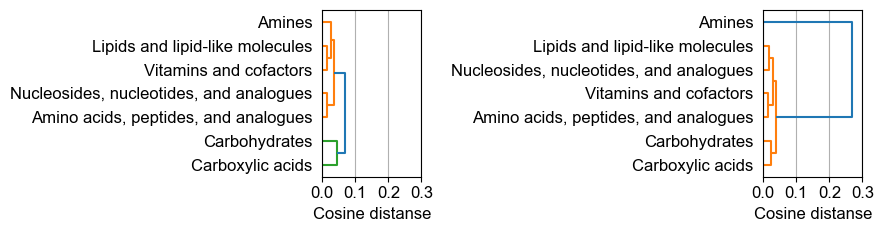

In [40]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(9,2.48))
dendrogram(row_linkage_pos_rot, labels=plot_data_pos.index, orientation='right', 
                            ax=ax[0])
dendrogram(row_linkage_neg_rot, labels=plot_data_neg.index, orientation='right', 
                            ax=ax[1])

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_xticks([0, 0.1, 0.2, 0.3])
ax[1].set_xticks([0, 0.1, 0.2, 0.3])
ax[0].grid(True, axis='x')
ax[1].grid(True, axis='x')
ax[0].set(xlabel = "Cosine distanse")
ax[1].set_xlabel("Cosine distanse")

fig.tight_layout()

fig.savefig(p_out / f"Class dendrograms.png")
fig.savefig(p_out/ f"Class dendrograms.pdf", transparent=True)

In [43]:
# Compute dengrogram for pos mode
col_distances_pos = pdist(plot_data_pos.T.values, metric='cosine')
col_linkage_pos = linkage(col_distances_pos, method='average')
col_linkage_pos

# I rotated some nodes without changing connectivity
col_linkage_pos_rot = [[ 3.        ,  4.        ,  0.00107369,  2.        ],
       [ 13.        , 5.        ,  0.00146148,  3.        ],
       [ 14.        , 6.        ,  0.00449642,  4.        ],
       [ 1.        ,  2.        ,  0.00497738,  2.        ],
       [ 7.        ,  8.        ,  0.00522232,  2.        ],
       [16.        , 15.        ,  0.00593908,  6.        ],
       [10.        , 11.        ,  0.00918243,  2.        ],
       [ 0.        , 18.        ,  0.0144384 ,  7.        ],
       [ 17.        , 9.        ,  0.02037929,  3.        ],
       [12.        , 19.        ,  0.04225713,  3.        ],
       [20.        , 21.        ,  0.05755864, 10.        ],
       [23.        , 22.        ,  0.09405161, 13.        ]]

In [44]:
# Compute dendrogram for neg mode
col_distances_neg = pdist(plot_data_neg.T.values, metric='cosine')
col_linkage_neg = linkage(col_distances_neg, method='average')
col_linkage_neg

# # I rotated some nodes without changing connectivity
col_linkage_neg_rot = [[ 1.        ,  0.        ,  0.0032367 ,  2.        ],
       [ 2.        ,  3.        ,  0.0066249 ,  2.        ],
       [ 4.        ,  5.        ,  0.00955368,  2.        ],
       [12.        , 13.        ,  0.01235961,  3.        ],
       [ 15.        , 6.        ,  0.02153068,  3.        ],
       [14.        , 17.        ,  0.02505133,  5.        ],
       [10.        , 16.        ,  0.02645539,  4.        ],
       [ 7.        ,  8.        ,  0.03206897,  2.        ],
       [19.        , 18.        ,  0.03457888,  9.        ],
       [ 21.        , 9.        ,  0.04845468, 10.        ],
       [22.        , 11.        ,  0.06528975, 11.        ],
       [23.        , 20.        ,  0.07896132, 13.        ]]

C:\Users\saharuka\AppData\Local\Temp\ipykernel_15836\3680711553.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


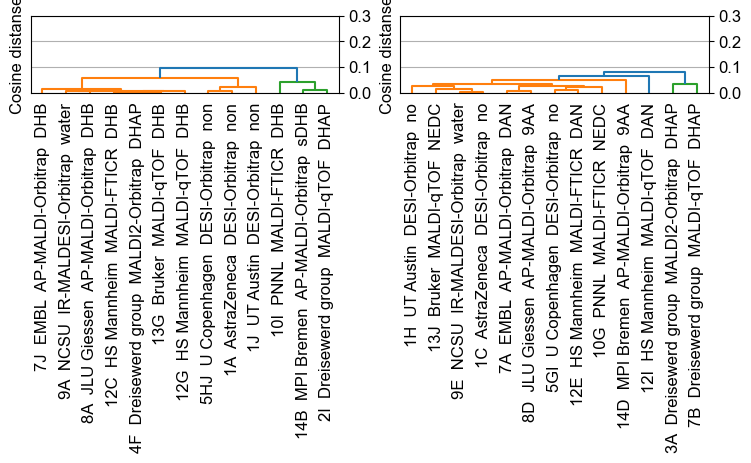

In [55]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8.75,1))
dendrogram(col_linkage_pos_rot, labels=plot_data_pos.T.index, orientation='top', 
                            ax=ax[0])
dendrogram(col_linkage_neg_rot, labels=plot_data_neg.T.index, orientation='top', 
                            ax=ax[1])

ax[0].set_yticks([0, 0.1, 0.2, 0.3])
ax[1].set_yticks([0, 0.1, 0.2, 0.3])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

ax[0].grid(True, axis='y')
ax[1].grid(True, axis='y')
ax[0].set_ylabel("Cosine distanse")
ax[1].set_ylabel("Cosine distanse")

ax[0].yaxis.tick_left()
ax[0].yaxis.set_ticks_position('right')
ax[1].yaxis.tick_left()
ax[1].yaxis.set_ticks_position('right')

fig.tight_layout()

fig.savefig(p_out / f"Instrument dendrograms.png")
fig.savefig(p_out/ f"Instrument dendrograms.pdf", transparent=True)

C:\Users\saharuka\.conda\envs\batch\lib\site-packages\seaborn\matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)
C:\Users\saharuka\AppData\Local\Temp\ipykernel_15836\1232013193.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
meta NOT subset; don't know how to subset; dropped


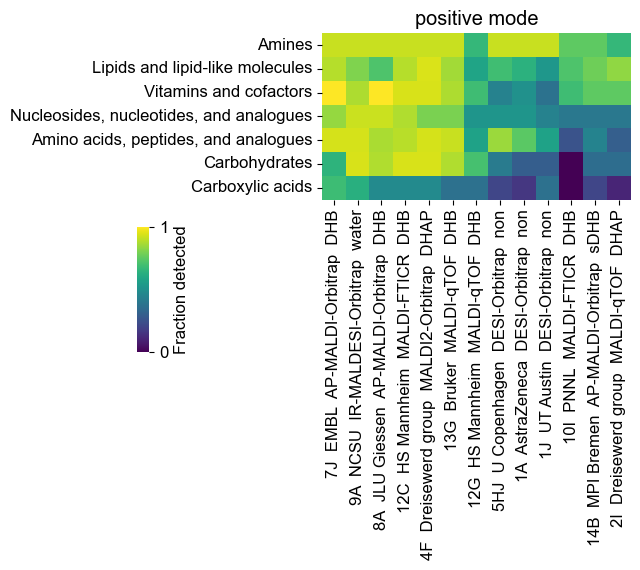

In [35]:
# Define the colorbar position and width
cbar_pos = (0, -0.5, 0.02, 0.5)  # (left, bottom, width, height)
cbar_kws = {'label': 'Fraction detected', 'ticks':[0,1]}

c = sns.clustermap(plot_data_pos, row_linkage=row_linkage_pos_rot, col_linkage=col_linkage_pos_rot, 
                   cmap="viridis", dendrogram_ratio=0.05,
                  cbar_pos=cbar_pos, cbar_kws=cbar_kws, vmax=1,
                  figsize=(6,2.5))
c.ax_row_dendrogram.remove()
c.ax_col_dendrogram.remove()
c.ax_heatmap.set(aspect=1, title = f"positive mode", xlabel="", ylabel="")
c.ax_heatmap.yaxis.tick_left()
c.ax_heatmap.yaxis.set_ticks_position('left')

plt.tight_layout()

c.savefig(p_out / f"Heatmap positive.png")
c.savefig(p_out/ f"Heatmap positive.pdf", transparent=True)

C:\Users\saharuka\AppData\Local\Temp\ipykernel_15836\3699804846.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
meta NOT subset; don't know how to subset; dropped


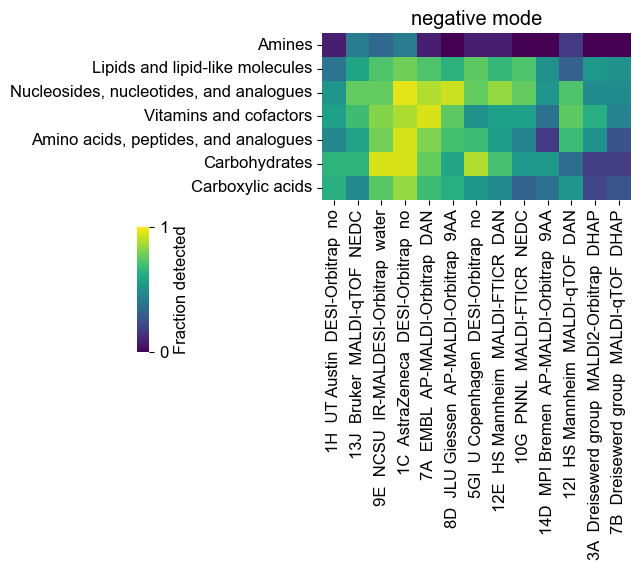

In [36]:
# Define the colorbar negition and width
cbar_neg = (0, -0.5, 0.02, 0.5)  # (left, bottom, width, height)
cbar_kws = {'label': 'Fraction detected', 'ticks':[0,1]}

c = sns.clustermap(plot_data_neg, row_linkage=row_linkage_neg_rot, col_linkage=col_linkage_neg_rot, 
                   cmap="viridis", dendrogram_ratio=0.05,
                  cbar_pos=cbar_neg, cbar_kws=cbar_kws, vmax=1,
                  figsize=(6,2.5))
c.ax_row_dendrogram.remove()
c.ax_col_dendrogram.remove()
c.ax_heatmap.set(aspect=1, title = f"negative mode", xlabel="", ylabel="")
c.ax_heatmap.yaxis.tick_left()
c.ax_heatmap.yaxis.set_ticks_position('left')

plt.tight_layout()

c.savefig(p_out / f"Heatmap negative.png")
c.savefig(p_out/ f"Heatmap negative.pdf", transparent=True)